# Simulation Ensembling Analysis (With Diagnostics)

This notebook runs a full simulation study and **uses the evaluation helpers** to:
- compare losses across ensemble methods
- plot cumulative/rolling losses
- inspect concentration (HHI) dynamics
- summarize what is happening along the way


In [101]:
import ast
import csv
import math
import sys
import warnings
import importlib
import inspect
from pathlib import Path
from typing import Dict, List

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

warnings.filterwarnings("ignore", category=SyntaxWarning)

PROJECT_ROOT = Path.cwd().resolve().parent if Path.cwd().name == "analyses" else Path.cwd().resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

NOTEBOOK_DIR = Path.cwd().resolve() if Path.cwd().name == "analyses" else PROJECT_ROOT / "analyses"
OUT_DIR = NOTEBOOK_DIR / "results"
OUT_DIR.mkdir(parents=True, exist_ok=True)

import src.data.simulator as simulator
import src.ensemblers.ensemblers as ensemblers
import src.evaluation.evaluation_helpers as eh
import src.evaluation.optuna_tuning as ot

# Avoid stale kernel/module state after source edits.
simulator = importlib.reload(simulator)

sig = inspect.signature(simulator.make_environment_and_forecasts)
if "scenario" not in sig.parameters:
    raise RuntimeError(
        "Loaded simulator does not expose 'scenario'. "
        "Restart kernel and ensure you're importing src.data.simulator from this repo."
    )

print(f"Project root: {PROJECT_ROOT}")
print(f"Output dir: {OUT_DIR}")
print(f"simulator module: {simulator.__file__}")
print(f"make_environment_and_forecasts signature: {sig}")


Project root: /home/clayt/Ensemble-Forecasting
Output dir: /home/clayt/Ensemble-Forecasting/analyses/results
simulator module: /home/clayt/Ensemble-Forecasting/src/data/simulator.py
make_environment_and_forecasts signature: (T: int = 600, horizons: List[int] = [1, 4, 8], window: int = 120, seed: int = 0, include_oracle: bool = True, scenario: Literal['baseline', 'discriminating'] = 'baseline', forecaster_noise_std: Optional[float] = None, forecaster_bias_std: Optional[float] = None) -> Tuple[Dict[str, numpy.ndarray], Dict[int, numpy.ndarray], List[str], numpy.ndarray]


In [102]:
def mse(y: np.ndarray, yhat: np.ndarray) -> float:
    e = y - yhat
    return float(np.mean(e * e))


def mae(y: np.ndarray, yhat: np.ndarray) -> float:
    return float(np.mean(np.abs(y - yhat)))


def linex(y: np.ndarray, yhat: np.ndarray, a: float = 1.0) -> float:
    e = y - yhat
    return float(np.mean(np.exp(a * e) - a * e - 1.0))


def hhi(weights: np.ndarray) -> float:
    w = np.asarray(weights, dtype=float)
    if w.ndim != 2:
        return math.nan
    valid = np.all(np.isfinite(w), axis=1)
    if not np.any(valid):
        return math.nan
    return float(np.mean(np.sum(w[valid] ** 2, axis=1)))


def helpers_from_source(path: Path) -> List[str]:
    tree = ast.parse(path.read_text(), filename=str(path))
    names: List[str] = []
    for node in tree.body:
        if isinstance(node, (ast.FunctionDef, ast.ClassDef)) and not node.name.startswith("_"):
            names.append(node.name)
    return sorted(names)


def align_for_horizon(
    pi: np.ndarray,
    forecasts_h: np.ndarray,
    s_unc: np.ndarray,
    h: int,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    y_target = pi[h:]
    F = forecasts_h[:-h]
    s = s_unc[:-h]
    mask = np.isfinite(y_target) & np.isfinite(s) & np.all(np.isfinite(F), axis=1)
    return y_target[mask], F[mask], s[mask]


def build_models(params_map: Dict[str, Dict[str, float]] | None = None):
    p = dict(ot.DEFAULT_METHOD_PARAMS)
    if params_map is not None:
        for k, v in params_map.items():
            p[k] = dict(v)

    return {
        "Mean": ensemblers.MeanEnsembler(),
        "Median": ensemblers.MedianEnsembler(),
        "OGDVanilla": ensemblers.OGDVanilla(eta=float(p["OGDVanilla"].get("eta", 0.05)), loss="squared"),
        "MWUMVanilla": ensemblers.MWUMVanilla(eta=float(p["MWUMVanilla"].get("eta", 0.30)), loss="squared"),
        "OGDBoth": ensemblers.OGDConcentrationBoth(
            eta=float(p["OGDBoth"].get("eta", 0.05)),
            kappa=float(p["OGDBoth"].get("kappa", 0.80)),
            loss="squared",
        ),
        "OGDConcOnly": ensemblers.OGDConcentrationOnly(
            kappa=float(p["OGDConcOnly"].get("kappa", 0.80)), loss="squared"
        ),
        "MWUMBothKL": ensemblers.MWUMBothKL(
            eta=float(p["MWUMBothKL"].get("eta", 0.30)),
            kappa=float(p["MWUMBothKL"].get("kappa", 0.80)),
            loss="squared",
        ),
        "MWUMConcOnlyKL": ensemblers.MWUMConcentrationOnlyKL(
            kappa=float(p["MWUMConcOnlyKL"].get("kappa", 0.80)), loss="squared"
        ),
    }


def evaluate_one_seed(
    seed: int,
    horizons: List[int],
    T: int,
    window: int,
    scenario: str = "discriminating",
    params_map_by_h: Dict[int, Dict[str, Dict[str, float]]] | None = None,
) -> List[Dict[str, float]]:
    data, forecasts_by_h, names, s_unc = simulator.make_environment_and_forecasts(
        T=T, horizons=horizons, window=window, seed=seed, include_oracle=False, scenario=scenario
    )
    pi = data["pi"]
    rows: List[Dict[str, float]] = []

    for h in horizons:
        y, F, s = align_for_horizon(pi, forecasts_by_h[h], s_unc, h)
        individual_mses = [mse(y, F[:, i]) for i in range(F.shape[1])]
        best_idx = int(np.argmin(individual_mses))
        best_individual_mse = float(individual_mses[best_idx])

        params_map = None
        if params_map_by_h is not None and h in params_map_by_h:
            params_map = params_map_by_h[h]
        models = build_models(params_map)

        for name, model in models.items():
            needs_state = name in ot.STATE_METHODS
            result = model.run(F, y, s=s if needs_state else None)
            rows.append({
                "seed": float(seed),
                "horizon": float(h),
                "method": name,
                "n_obs": float(y.size),
                "mse": mse(y, result.yhat),
                "mae": mae(y, result.yhat),
                "linex_a1": linex(y, result.yhat, a=1.0),
                "avg_hhi": hhi(result.weights),
                "best_individual_mse": best_individual_mse,
                "best_individual_idx": float(best_idx),
            })

    return rows


def aggregate(rows: List[Dict[str, float]]) -> pd.DataFrame:
    out: List[Dict[str, float]] = []
    keys = sorted({(r["horizon"], r["method"]) for r in rows})
    for horizon, method in keys:
        grp = [r for r in rows if r["horizon"] == horizon and r["method"] == method]
        mses = np.array([r["mse"] for r in grp], dtype=float)
        maes = np.array([r["mae"] for r in grp], dtype=float)
        linexes = np.array([r["linex_a1"] for r in grp], dtype=float)
        hhis = np.array([r["avg_hhi"] for r in grp], dtype=float)
        bests = np.array([r["best_individual_mse"] for r in grp], dtype=float)

        finite_hhi = hhis[np.isfinite(hhis)]
        avg_hhi_mean = float(np.mean(finite_hhi)) if finite_hhi.size else math.nan

        out.append({
            "horizon": horizon,
            "method": method,
            "mse_mean": float(np.mean(mses)),
            "mse_std": float(np.std(mses)),
            "mae_mean": float(np.mean(maes)),
            "linex_mean": float(np.mean(linexes)),
            "avg_hhi_mean": avg_hhi_mean,
            "avg_excess_mse_vs_best_individual": float(np.mean(mses - bests)),
        })
    df = pd.DataFrame(out).sort_values(["horizon", "mse_mean"]).reset_index(drop=True)
    return df


## 1) What Helpers Do We Have?

Inventory of helper functions/classes in the simulation, ensembling, and evaluation modules.


In [103]:
SIM_HELPERS = helpers_from_source(PROJECT_ROOT / "src" / "data" / "simulator.py")
ENS_HELPERS = helpers_from_source(PROJECT_ROOT / "src" / "ensemblers" / "ensemblers.py")
EVAL_HELPERS = helpers_from_source(PROJECT_ROOT / "src" / "evaluation" / "evaluation_helpers.py")
TUNE_HELPERS = helpers_from_source(PROJECT_ROOT / "src" / "evaluation" / "optuna_tuning.py")

display(pd.DataFrame({"src.data.simulator": pd.Series(SIM_HELPERS)}))
display(pd.DataFrame({"src.ensemblers.ensemblers": pd.Series(ENS_HELPERS)}))
display(pd.DataFrame({"src.evaluation.evaluation_helpers": pd.Series(EVAL_HELPERS)}))
display(pd.DataFrame({"src.evaluation.optuna_tuning": pd.Series(TUNE_HELPERS)}))


,src.data.simulator
0,MacroSimConfig
1,build_forecaster_panel
2,make_environment_and_forecasts
3,simulate_macro_environment


,src.ensemblers.ensemblers
0,BaseEnsembler
1,EnsembleResult
2,MWUMBothKL
3,MWUMConcentrationOnlyKL
4,MWUMVanilla
5,MeanEnsembler
6,MedianEnsembler
7,OGDConcentrationBoth
8,OGDConcentrationOnly
9,OGDVanilla


,src.evaluation.evaluation_helpers
0,best_forecaster_yhat
1,cumulative_loss
2,evaluate_and_plot
3,hhi_from_weights
4,linex_loss
5,loss_series
6,loss_table
7,mae
8,mse
9,plot_actions_over_time


,src.evaluation.optuna_tuning
0,TuneResult
1,tune_all_methods_optuna
2,tune_method_optuna


## 2) Simulated Macro Background EDA

Before evaluating ensemblers, inspect the simulated macro environment (levels, regimes, uncertainty, and cross-variable relationships).


In [104]:
SEED_BG = 3
T_BG = 2200

data_bg, _, _, s_unc_bg = simulator.make_environment_and_forecasts(
    T=T_BG, horizons=[1], window=150, seed=SEED_BG, include_oracle=False, scenario="discriminating"
)

df_bg = pd.DataFrame({
    "pi": data_bg["pi"],
    "x": data_bg["x"],
    "i": data_bg["i"],
    "u": data_bg["u"],
    "sigma_pi": data_bg["sigma_pi"],
    "regime": data_bg["regime"],
    "state_uncertainty": s_unc_bg,
})

print(f"Background sample size: {len(df_bg)}")
display(df_bg.head())
display(df_bg[["pi","x","i","u","sigma_pi","state_uncertainty"]].describe().T)


Background sample size: 2100


,pi,x,i,u,sigma_pi,regime,state_uncertainty
0,0.311852,0.527425,0.745895,1.294849,0.231517,0,0.571909
1,0.201732,0.048041,0.330179,2.386292,0.224716,0,0.555108
2,-0.256252,-0.073779,-0.474907,0.692626,0.248377,0,0.613557
3,0.083671,0.573828,0.532879,1.314601,0.210146,0,0.519115
4,0.281361,0.329458,0.599357,3.816655,0.234423,0,0.579088


,count,mean,std,min,25%,50%,75%,max
pi,2100.0,0.113927,1.883857,-8.020424,-0.454533,0.038740,0.719495,7.381375
x,2100.0,-0.012040,1.275649,-6.206810,-0.592659,0.042876,0.634189,6.037292
i,2100.0,0.113841,1.779195,-8.622367,-0.689549,0.079091,0.928391,7.299234
u,2100.0,0.046552,1.671642,-5.715337,-1.071033,0.041770,1.194499,5.363928
sigma_pi,2100.0,0.404815,0.221948,0.059059,0.214689,0.371748,0.555155,1.442201
state_uncertainty,2100.0,1.000000,0.548271,0.145891,0.530340,0.918317,1.371381,3.562618


In [105]:
regime_share = (
    df_bg["regime"].value_counts(normalize=True).sort_index().rename("share").to_frame()
)
regime_share.index = [f"regime_{int(i)}" for i in regime_share.index]
display(regime_share)

corr = df_bg[["pi","x","i","u","sigma_pi","state_uncertainty"]].corr()
display(corr)


,share
regime_0,0.412381
regime_1,0.346190
regime_2,0.241429


,pi,x,i,u,sigma_pi,state_uncertainty
pi,1.000000,0.086712,0.942076,0.486263,-0.028742,-0.028742
x,0.086712,1.000000,0.217248,0.020590,-0.071118,-0.071118
i,0.942076,0.217248,1.000000,0.510754,-0.032359,-0.032359
u,0.486263,0.020590,0.510754,1.000000,0.008333,0.008333
sigma_pi,-0.028742,-0.071118,-0.032359,0.008333,1.000000,1.000000
state_uncertainty,-0.028742,-0.071118,-0.032359,0.008333,1.000000,1.000000


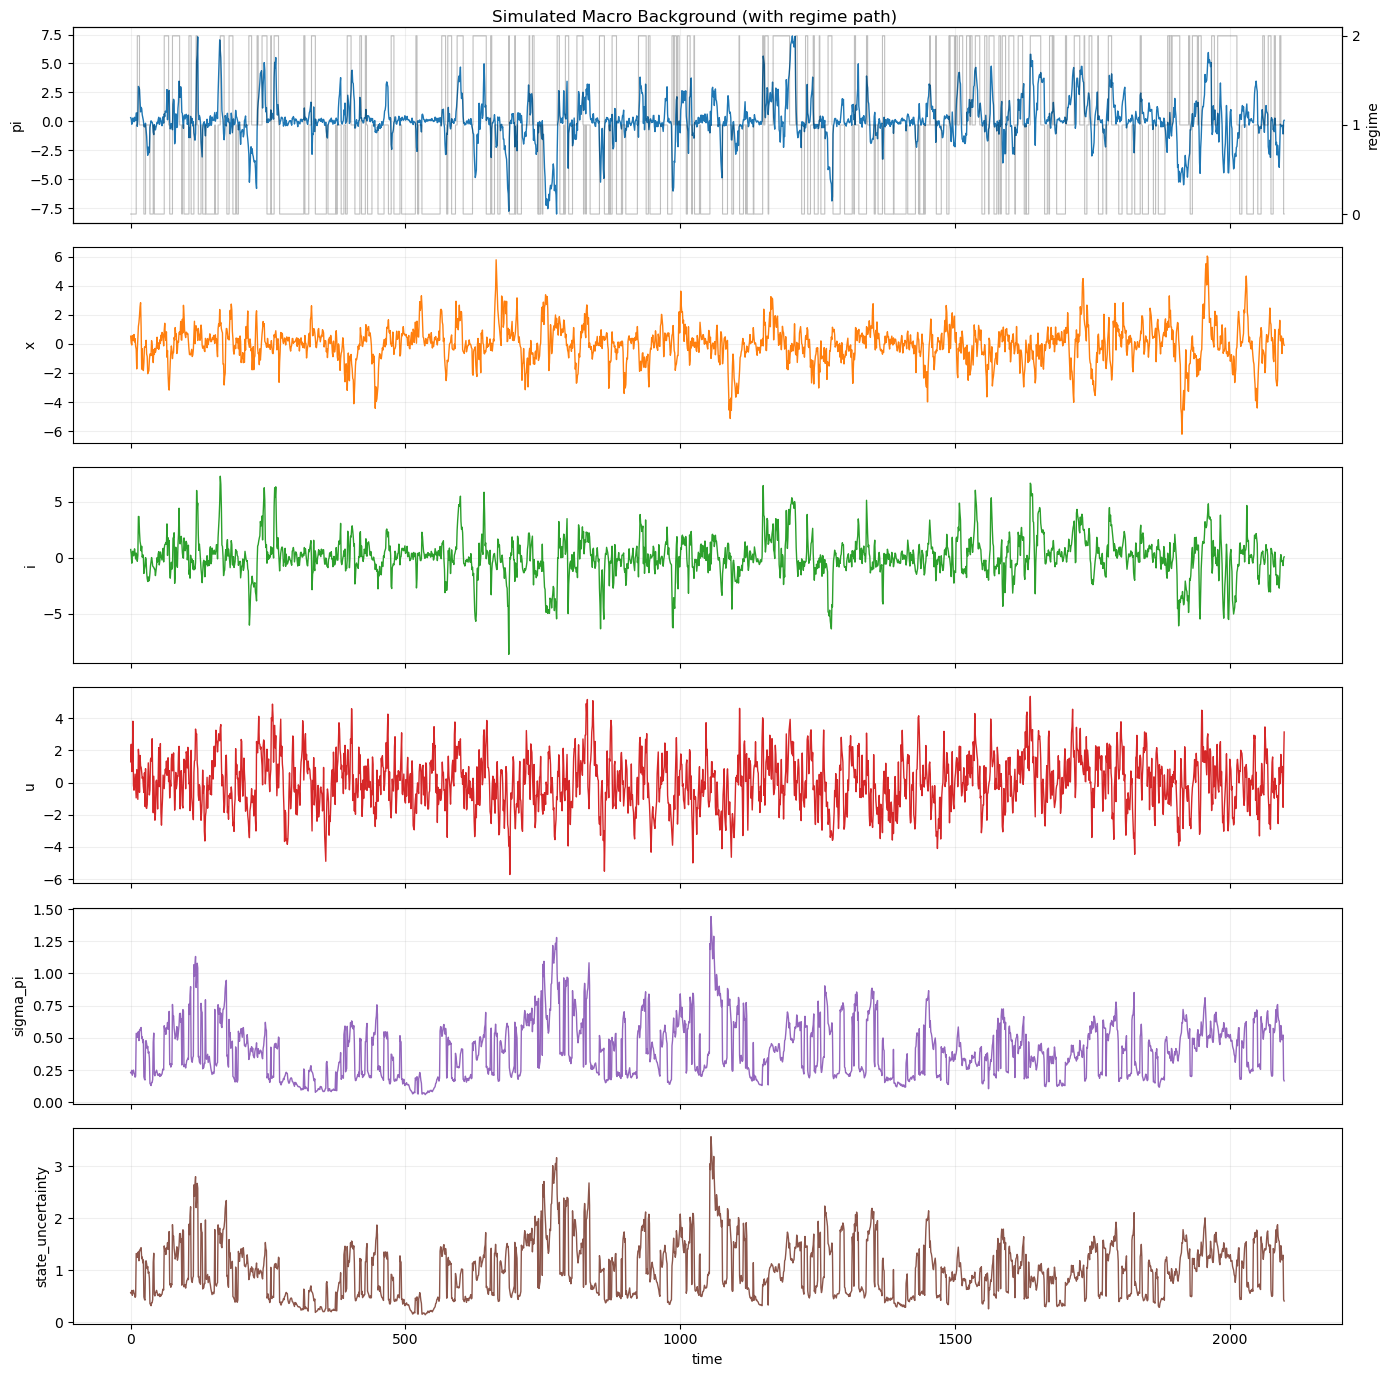

In [106]:
# Time-series view with regime path
t = np.arange(len(df_bg))
fig, axes = plt.subplots(6, 1, figsize=(14, 14), sharex=True)

series = ["pi", "x", "i", "u", "sigma_pi", "state_uncertainty"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
for ax, sname, c in zip(axes, series, colors):
    ax.plot(t, df_bg[sname].to_numpy(), color=c, linewidth=1.0)
    ax.set_ylabel(sname)
    ax.grid(alpha=0.2)

axr = axes[0].twinx()
axr.step(t, df_bg["regime"].to_numpy(), where="post", color="black", alpha=0.25, linewidth=0.8)
axr.set_ylabel("regime", color="black")
axr.set_yticks([0,1,2])

axes[-1].set_xlabel("time")
fig.suptitle("Simulated Macro Background (with regime path)")
plt.tight_layout()
plt.show()


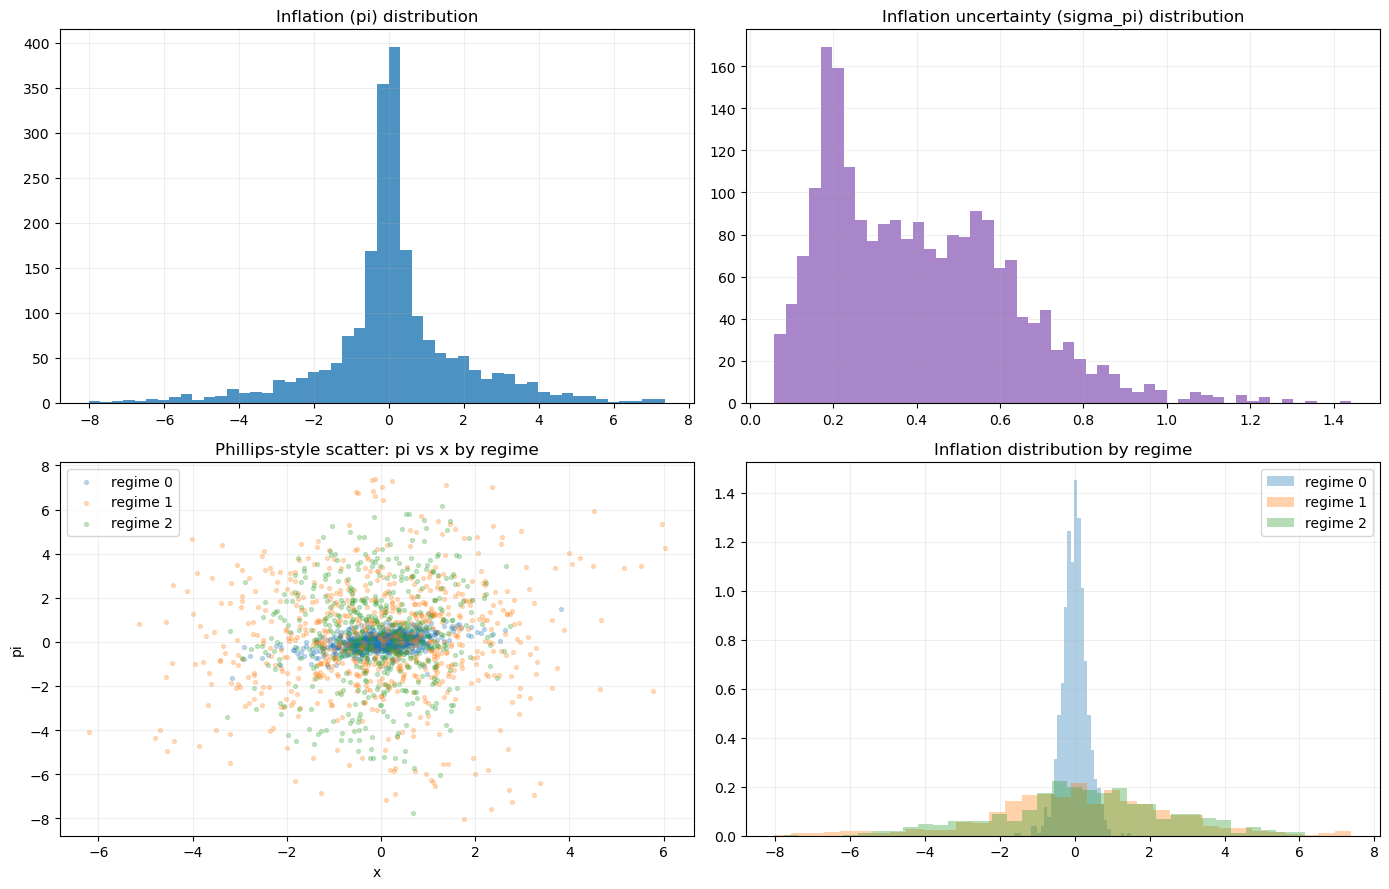

In [107]:
# Distribution and regime-conditional views
fig, axes = plt.subplots(2, 2, figsize=(14, 9))

axes[0,0].hist(df_bg["pi"], bins=50, color="#1f77b4", alpha=0.8)
axes[0,0].set_title("Inflation (pi) distribution")

axes[0,1].hist(df_bg["sigma_pi"], bins=50, color="#9467bd", alpha=0.8)
axes[0,1].set_title("Inflation uncertainty (sigma_pi) distribution")

for r, c in zip(sorted(df_bg["regime"].unique()), ["#1f77b4", "#ff7f0e", "#2ca02c"]):
    sub = df_bg[df_bg["regime"] == r]
    axes[1,0].scatter(sub["x"], sub["pi"], s=8, alpha=0.25, color=c, label=f"regime {int(r)}")
axes[1,0].set_title("Phillips-style scatter: pi vs x by regime")
axes[1,0].set_xlabel("x")
axes[1,0].set_ylabel("pi")
axes[1,0].legend()

for r, c in zip(sorted(df_bg["regime"].unique()), ["#1f77b4", "#ff7f0e", "#2ca02c"]):
    sub = df_bg[df_bg["regime"] == r]
    axes[1,1].hist(sub["pi"], bins=35, alpha=0.35, color=c, density=True, label=f"regime {int(r)}")
axes[1,1].set_title("Inflation distribution by regime")
axes[1,1].legend()

for ax in axes.ravel():
    ax.grid(alpha=0.2)

plt.tight_layout()
plt.show()


### EDA Interpretation
- The regime process is persistent (long stretches in each state), not i.i.d.
- `sigma_pi` and `state_uncertainty` vary substantially over time, motivating state-dependent regularization (`lambda_t = kappa * s_t`).
- The `pi`-`x` relationship changes by regime, so static linear pooling can be suboptimal relative to adaptive ensembling.
- Distribution shifts and volatility clustering imply online methods should react differently across tranquil vs turbulent intervals.


## 3) Optuna Hyperparameter Tuning + Multi-Seed Aggregate Experiment

Tune all tunable ensemblers (`eta`, `kappa`) with Optuna on training seeds, then evaluate on held-out seeds.


In [108]:
SCENARIO = "discriminating"
HORIZONS = [1, 4, 8]
T = 1400
WINDOW = 150

TUNING_SEEDS = [0, 1, 2, 3]
TEST_SEEDS = [4, 5, 6, 7, 8, 9]
N_TRIALS = 35
REQUIRE_OPTUNA = True

methods = list(ot.DEFAULT_METHOD_PARAMS.keys())
TUNING_MODE = "optuna_by_horizon"
TUNED_PARAMS_BY_H = {}
tuning_rows = []

for h in HORIZONS:
    tuning_slices_h = []
    for seed in TUNING_SEEDS:
        data_t, forecasts_t, _, s_unc_t = simulator.make_environment_and_forecasts(
            T=T,
            horizons=HORIZONS,
            window=WINDOW,
            seed=seed,
            include_oracle=False,
            scenario=SCENARIO,
        )
        pi_t = data_t["pi"]
        y_t, F_t, s_t = align_for_horizon(pi_t, forecasts_t[h], s_unc_t, h)
        tuning_slices_h.append((y_t, F_t, s_t))

    try:
        tuning_results_h = ot.tune_all_methods_optuna(
            data_slices=tuning_slices_h,
            methods=methods,
            n_trials=N_TRIALS,
            seed=42 + 100 * h,
        )
    except ModuleNotFoundError as exc:
        if REQUIRE_OPTUNA:
            raise RuntimeError(
                "Optuna is required but not installed. Run `pip install optuna` and rerun this notebook."
            ) from exc
        TUNING_MODE = "default_params_fallback"
        tuning_results_h = {
            m: ot.TuneResult(method=m, best_params=dict(ot.DEFAULT_METHOD_PARAMS[m]), best_value=np.nan)
            for m in methods
        }

    TUNED_PARAMS_BY_H[h] = {m: dict(tuning_results_h[m].best_params) for m in methods}

    for m in methods:
        tuning_rows.append({
            "horizon": float(h),
            "method": m,
            "best_params": tuning_results_h[m].best_params,
            "tuning_objective_mse": tuning_results_h[m].best_value,
        })

tuning_table = pd.DataFrame(tuning_rows).sort_values(["horizon", "tuning_objective_mse"], na_position="last")
print(f"Tuning mode: {TUNING_MODE}")
display(tuning_table)

all_rows: List[Dict[str, float]] = []
for seed in TEST_SEEDS:
    all_rows.extend(
        evaluate_one_seed(
            seed=seed,
            horizons=HORIZONS,
            T=T,
            window=WINDOW,
            scenario=SCENARIO,
            params_map_by_h=TUNED_PARAMS_BY_H,
        )
    )

agg_df = aggregate(all_rows)
all_df = pd.DataFrame(all_rows)

print(f"Detailed rows: {len(all_df)}")
print(f"Aggregated rows: {len(agg_df)}")
display(agg_df)


/home/clayt/miniconda3/envs/ensemble/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2026-02-16 00:11:31,901] A new study created in memory with name: no-name-2b2094ab-3b54-4800-9430-a566230e5b47
[I 2026-02-16 00:11:31,905] A new study created in memory with name: no-name-25e9a21e-3e50-41a4-9892-c8513397d1b8
[I 2026-02-16 00:11:31,908] A new study created in memory with name: no-name-f4724488-be72-48bb-a23e-bd0513690f0f
[I 2026-02-16 00:11:32,051] Trial 0 finished with value: 0.9750400010255719 and parameters: {'eta': 0.008116076157212304}. Best is trial 0 with value: 0.9750400010255719.
[I 2026-02-16 00:11:32,258] Trial 1 finished with value: 0.9527323640132535 and parameters: {'eta': 0.00347441289862208}. Best is trial 1 with value: 0.9527323640132535.
[I 2026-02-16 00:11:32,388] Trial 2 finished w

Tuning mode: optuna_by_horizon


,horizon,method,best_params,tuning_objective_mse
3,1.0,MWUMVanilla,{'eta': 0.01580148447850615},0.927597
6,1.0,MWUMBothKL,"{'eta': 0.015919552043565138, 'kappa': 0.00571...",0.927607
1,1.0,Median,{},0.935141
2,1.0,OGDVanilla,{'eta': 0.001004380875007612},0.936317
4,1.0,OGDBoth,"{'eta': 0.001000231236412198, 'kappa': 0.05203...",0.936395
7,1.0,MWUMConcOnlyKL,{'kappa': 7.849943290518327},0.943678
0,1.0,Mean,{},0.951495
5,1.0,OGDConcOnly,{'kappa': 7.989067040220606},1.059112
15,4.0,MWUMConcOnlyKL,{'kappa': 0.28056807110434306},2.311048
14,4.0,MWUMBothKL,"{'eta': 2.9821867212394793, 'kappa': 0.5913228...",2.436337


Detailed rows: 144
Aggregated rows: 24


,horizon,method,mse_mean,mse_std,mae_mean,linex_mean,avg_hhi_mean,avg_excess_mse_vs_best_individual
0,1.0,MWUMBothKL,0.826009,0.122314,0.617038,0.747451,0.067552,-0.030459
1,1.0,MWUMVanilla,0.826031,0.122287,0.617056,0.747249,0.067816,-0.030437
2,1.0,Median,0.831550,0.123758,0.618771,0.740750,NaN,-0.024918
3,1.0,OGDVanilla,0.832068,0.123777,0.621766,0.754473,0.060297,-0.024401
4,1.0,OGDBoth,0.832132,0.123770,0.621802,0.754368,0.060116,-0.024336
5,1.0,MWUMConcOnlyKL,0.840317,0.126578,0.625177,0.752177,0.056578,-0.016152
6,1.0,Mean,0.844159,0.127278,0.632936,0.721882,0.055556,-0.012310
7,1.0,OGDConcOnly,0.924945,0.147789,0.653468,0.891140,0.085963,0.068476
8,4.0,MWUMConcOnlyKL,2.096883,0.397891,0.997704,3.465292,0.295661,-0.888328
9,4.0,MWUMBothKL,2.223516,0.409887,1.036699,3.622916,0.191595,-0.761695


### Quick Interpretation

Below we print the best method by MSE per horizon from the aggregate table.


In [109]:
for h in HORIZONS:
    sub = agg_df[agg_df["horizon"] == float(h)].sort_values("mse_mean")
    top = sub.iloc[0]
    print(
        f"h={h}: best={top['method']} | MSE={top['mse_mean']:.4f}, MAE={top['mae_mean']:.4f}, \
LINEX={top['linex_mean']:.4f}, avg HHI={top['avg_hhi_mean']:.4f}"
    )


h=1: best=MWUMBothKL | MSE=0.8260, MAE=0.6170, LINEX=0.7475, avg HHI=0.0676
h=4: best=MWUMConcOnlyKL | MSE=2.0969, MAE=0.9977, LINEX=3.4653, avg HHI=0.2957
h=8: best=MWUMConcOnlyKL | MSE=2.6249, MAE=1.1190, LINEX=5.1589, avg HHI=0.3003


## 4) Walkthrough With Evaluation Helpers (Single Scenario)

Now we use `src/evaluation/evaluation_helpers.py` directly to **plot and diagnose what happens over time** for one representative run.


In [110]:
SEED_DEMO = 4
H_DEMO = 4

if "TUNED_PARAMS_BY_H" not in globals():
    print("TUNED_PARAMS_BY_H not found; using default params for all horizons.")
    TUNED_PARAMS_BY_H = {h: {m: dict(v) for m, v in ot.DEFAULT_METHOD_PARAMS.items()} for h in [1, 4, 8]}
if "SCENARIO" not in globals():
    SCENARIO = "discriminating"
if "HORIZONS" not in globals():
    HORIZONS = [1, 4, 8]
if "T" not in globals():
    T = 1400
if "WINDOW" not in globals():
    WINDOW = 150

data_demo, forecasts_by_h_demo, names_demo, s_unc_demo = simulator.make_environment_and_forecasts(
    T=T, horizons=HORIZONS, window=WINDOW, seed=SEED_DEMO, include_oracle=False, scenario=SCENARIO
)

y_demo, F_demo, s_demo = align_for_horizon(data_demo["pi"], forecasts_by_h_demo[H_DEMO], s_unc_demo, H_DEMO)

models_demo = build_models(TUNED_PARAMS_BY_H.get(H_DEMO))

yhats_demo: Dict[str, np.ndarray] = {}
weights_demo: Dict[str, np.ndarray] = {}
for name, model in models_demo.items():
    needs_state = name in ot.STATE_METHODS
    res = model.run(F_demo, y_demo, s=s_demo if needs_state else None)
    yhats_demo[name] = res.yhat
    weights_demo[name] = res.weights

print(f"Demo setup: scenario={SCENARIO}, seed={SEED_DEMO}, horizon={H_DEMO}, observations={len(y_demo)}, experts={F_demo.shape[1]}")


Demo setup: scenario=discriminating, seed=4, horizon=4, observations=1020, experts=18


In [111]:
# Evaluation helper: summary loss table vs best individual forecaster
table_demo = eh.loss_table(
    y=y_demo,
    F_individual=F_demo,
    yhats=yhats_demo,
    metric="mse",
    include_best_forecaster=True,
    forecaster_names=names_demo,
)
display(table_demo)


,Model,MSE
0,MWUMConcOnlyKL,2.653673
1,MWUMBothKL,2.776338
2,OGDBoth,2.873158
3,OGDVanilla,2.899995
4,OGDConcOnly,3.292164
5,Best forecaster: AR1_long,3.824245
6,MWUMVanilla,3.858274
7,Median,4.035734
8,Mean,4.056343


### What This Table Says
- The top row is the lowest MSE in this demo scenario.
- The best-individual row is the strongest single forecaster benchmark.
- Ensemble rows below that show whether online weighting beats static/individual baselines.


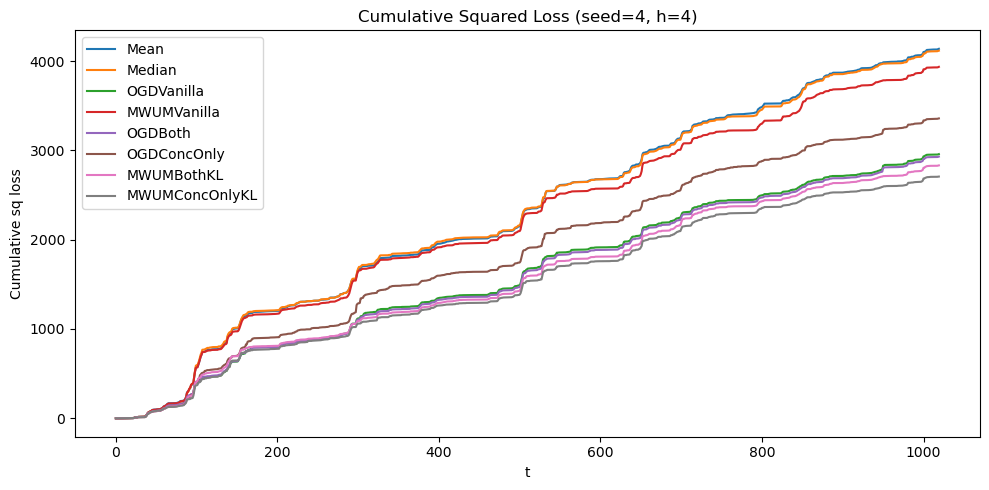

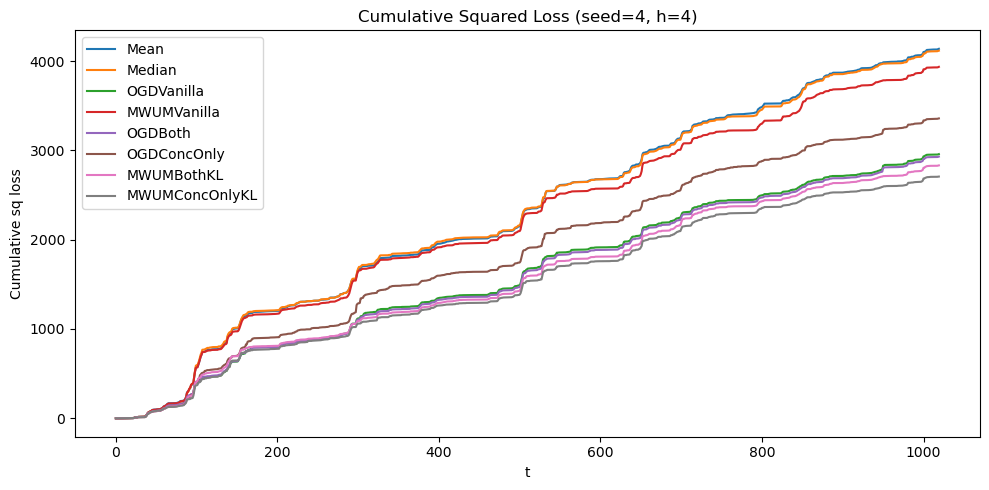

In [112]:
# Evaluation helper: cumulative squared loss trajectories
eh.plot_loss_over_time(
    y=y_demo,
    yhats=yhats_demo,
    loss="sq",
    mode="cumulative",
    title=f"Cumulative Squared Loss (seed={SEED_DEMO}, h={H_DEMO})",
)


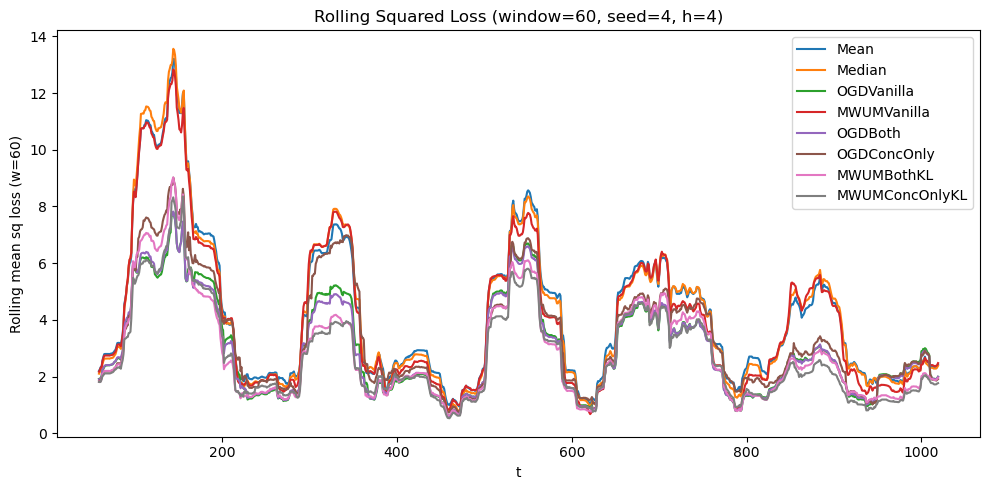

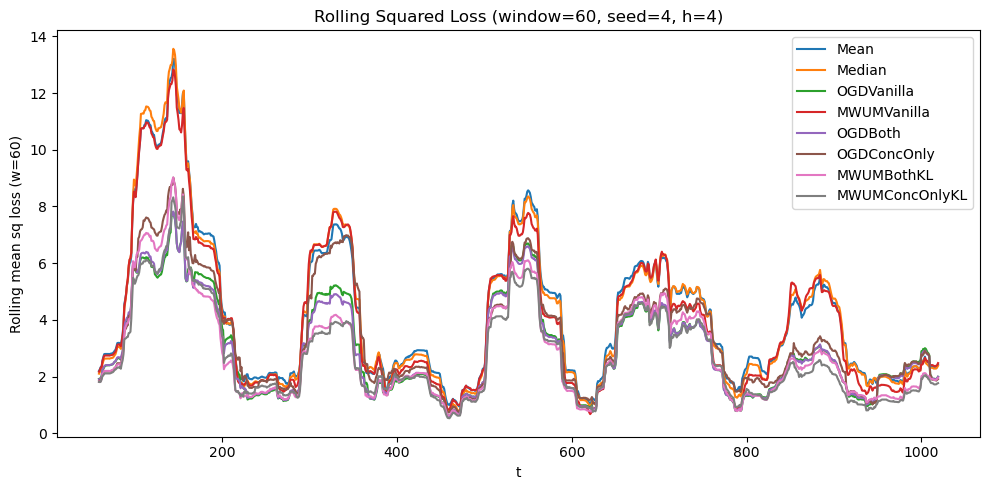

In [113]:
# Evaluation helper: rolling loss to see local regime-performance changes
eh.plot_loss_over_time(
    y=y_demo,
    yhats=yhats_demo,
    loss="sq",
    mode="rolling",
    rolling_window=60,
    title=f"Rolling Squared Loss (window=60, seed={SEED_DEMO}, h={H_DEMO})",
)


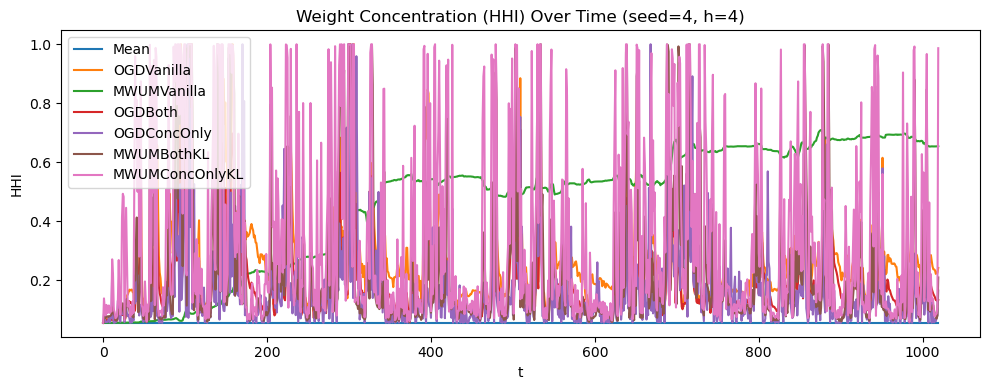

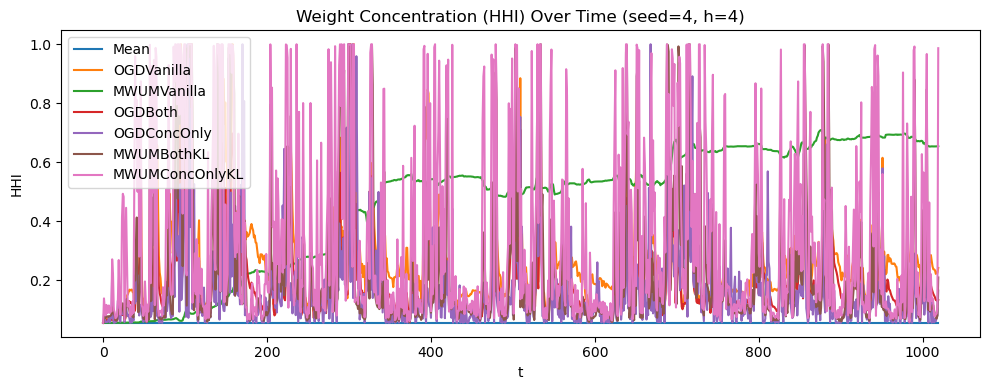

In [114]:
# Evaluation helper: concentration dynamics (HHI) from ensemble weights
weights_plot = {k: v for k, v in weights_demo.items() if np.isfinite(v).all()}
eh.plot_hhi_over_time(
    weights_dict=weights_plot,
    title=f"Weight Concentration (HHI) Over Time (seed={SEED_DEMO}, h={H_DEMO})",
)


In [115]:
# Programmatic narrative from the demo outputs
winner = table_demo.iloc[0]
runner = table_demo.iloc[1]

hhi_avg = {name: eh.hhi_from_weights(W) for name, W in weights_plot.items()}
hhi_mean = {name: float(np.nanmean(v)) for name, v in hhi_avg.items()}

hhi_non_mean = {k: v for k, v in hhi_mean.items() if k != "Mean" and np.isfinite(v)}
most_concentrated = max(hhi_non_mean, key=hhi_non_mean.get)
most_diversified_ex_mean = min(hhi_non_mean, key=hhi_non_mean.get)

print("Interpretation:")
print(f"- Best method in this demo (by MSE): {winner['Model']} ({winner['MSE']:.4f})")
print(f"- Runner-up: {runner['Model']} ({runner['MSE']:.4f})")
print(f"- Most concentrated weighting (highest avg HHI, excluding Mean): {most_concentrated} ({hhi_non_mean[most_concentrated]:.4f})")
print(f"- Most diversified weighting (lowest avg HHI, excluding Mean): {most_diversified_ex_mean} ({hhi_non_mean[most_diversified_ex_mean]:.4f})")
print("- In cumulative-loss plots, flatter slope means better ongoing forecast performance.")


Interpretation:
- Best method in this demo (by MSE): MWUMConcOnlyKL (2.6537)
- Runner-up: MWUMBothKL (2.7763)
- Most concentrated weighting (highest avg HHI, excluding Mean): MWUMVanilla (0.4594)
- Most diversified weighting (lowest avg HHI, excluding Mean): OGDConcOnly (0.1636)
- In cumulative-loss plots, flatter slope means better ongoing forecast performance.


## 5) Persist Results

Save detailed/summary metrics and a markdown report for downstream use.


In [116]:
def write_csv(path: Path, rows: List[Dict[str, float]]) -> None:
    if not rows:
        return
    fieldnames = list(rows[0].keys())
    with path.open("w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=fieldnames)
        w.writeheader()
        w.writerows(rows)


def write_report(
    path: Path,
    sim_helpers: List[str],
    ens_helpers: List[str],
    eval_helpers: List[str],
    tune_helpers: List[str],
    tuning_table: pd.DataFrame,
    agg_df: pd.DataFrame,
) -> None:
    lines: List[str] = []
    lines.append("# Simulation Ensembling Analysis\n")
    lines.append("## Module Helper Inventory\n")

    lines.append("### `src.data.simulator`")
    lines.extend([f"- `{x}`" for x in sim_helpers])

    lines.append("\n### `src.ensemblers.ensemblers`")
    lines.extend([f"- `{x}`" for x in ens_helpers])

    lines.append("\n### `src.evaluation.evaluation_helpers`")
    lines.extend([f"- `{x}`" for x in eval_helpers])

    lines.append("\n### `src.evaluation.optuna_tuning`")
    lines.extend([f"- `{x}`" for x in tune_helpers])

    lines.append("\n## Tuning Setup")
    lines.append(f"- Scenario: {SCENARIO}")
    lines.append(f"- Tuning seeds: {TUNING_SEEDS}")
    lines.append(f"- Test seeds: {TEST_SEEDS}")
    lines.append(f"- Optuna trials per method: {N_TRIALS}")
    lines.append(f"- Tuning mode: {TUNING_MODE}")

    lines.append("\n## Tuned Hyperparameters (by horizon)")
    for h in sorted(tuning_table["horizon"].unique()):
        lines.append(f"\n### Horizon h={int(h)}")
        sub = tuning_table[tuning_table["horizon"] == h].sort_values("tuning_objective_mse", na_position="last")
        for _, row in sub.iterrows():
            lines.append(f"- {row['method']}: params={row['best_params']}, objective_mse={row['tuning_objective_mse']}")

    lines.append("\n## Aggregated Results")
    for h in sorted(agg_df["horizon"].unique()):
        lines.append(f"\n### Horizon h={int(h)}")
        sub = agg_df[agg_df["horizon"] == h].sort_values("mse_mean")
        for _, r in sub.iterrows():
            lines.append(
                f"- {r['method']}: MSE={r['mse_mean']:.4f} (std {r['mse_std']:.4f}), MAE={r['mae_mean']:.4f}, "
                f"LINEX={r['linex_mean']:.4f}, avg HHI={r['avg_hhi_mean']:.4f}"
            )

    path.write_text("\n".join(lines) + "\n")


if "all_df" not in globals() or "agg_df" not in globals():
    raise RuntimeError("Run the tuning/evaluation section first (cell 'Optuna Hyperparameter Tuning + Multi-Seed Aggregate Experiment').")
if "tuning_table" not in globals():
    tuning_table = pd.DataFrame([
        {"horizon": np.nan, "method": m, "best_params": dict(v), "tuning_objective_mse": np.nan}
        for m, v in ot.DEFAULT_METHOD_PARAMS.items()
    ])
if "TUNING_MODE" not in globals():
    TUNING_MODE = "unknown"


detailed_csv = OUT_DIR / "simulation_ensemble_detailed.csv"
summary_csv = OUT_DIR / "simulation_ensemble_summary.csv"
report_md = OUT_DIR / "simulation_ensemble_report.md"
tuning_csv = OUT_DIR / "simulation_ensemble_tuned_params.csv"

write_csv(detailed_csv, all_df.to_dict(orient="records"))
write_csv(summary_csv, agg_df.to_dict(orient="records"))
write_csv(tuning_csv, tuning_table.to_dict(orient="records"))
write_report(report_md, SIM_HELPERS, ENS_HELPERS, EVAL_HELPERS, TUNE_HELPERS, tuning_table, agg_df)

print(f"Wrote: {detailed_csv}")
print(f"Wrote: {summary_csv}")
print(f"Wrote: {tuning_csv}")
print(f"Wrote: {report_md}")


Wrote: /home/clayt/Ensemble-Forecasting/analyses/results/simulation_ensemble_detailed.csv
Wrote: /home/clayt/Ensemble-Forecasting/analyses/results/simulation_ensemble_summary.csv
Wrote: /home/clayt/Ensemble-Forecasting/analyses/results/simulation_ensemble_tuned_params.csv
Wrote: /home/clayt/Ensemble-Forecasting/analyses/results/simulation_ensemble_report.md
